# Regression models for predicting solubility

Predicting solubility using sklearn's following regression models:
- Linear Regression
- Random Forest
- Gradient Boosting
- Support Vector Machine

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats
from scipy.special import inv_boxcox

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# loading dataset as pandas dataframe
df = pd.read_csv('curated_aqsoldb.csv')

##### Using descriptors based on Delaney's method - MolLogP, MolWt, NumRotatableBonds, AromaticProportion (AP) (https://pubmed.ncbi.nlm.nih.gov/15154768/)

Note: From my own EDA, I have found that MolLogP and MolWt have a much larger correlation to solubility that NumRotatableBonds and AromaticProportion

In [4]:
# creating X matrix from descriptors chosen
X = df[['MolLogP', 'MolWt', 'NumRotatableBonds', 'AP']]
X

,MolLogP,MolWt,NumRotatableBonds,AP
0,3.95810,392.510,17.0,0.000000
1,2.40550,169.183,0.0,0.769231
2,2.15250,140.569,1.0,0.666667
3,8.11610,756.226,10.0,0.679245
4,2.48540,422.525,12.0,0.387097
...,...,...,...,...
10058,2.61700,264.369,8.0,0.315789
10059,-0.21440,444.440,2.0,0.187500
10060,2.82402,150.221,1.0,0.545455
10061,5.09308,454.611,13.0,0.363636


In [5]:
# creating Y matrix from Solubility values
Y = df['Solubility']

In [6]:
# split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y)

### Box Cox Transformation
Transforming data so that we get normal distributions rather than the skewed distribution we saw in the EDA

In [7]:
# transform descriptor data and save lambda value
fitted_mw, mw_lambda = stats.boxcox(df['MolWt'])

# need to make all values positive for transformation so add smallest value needed to bring largest negative value over 0
df['pos_MolLogP'] = df['MolLogP'] + 40.9
fitted_mlogp, mlogp_lambda = stats.boxcox(df['pos_MolLogP'])

# no zeroes allowed so add 0.1 to all values
df['pos_AP'] = df['AP'] + 0.1
fitted_ap, ap_lambda = stats.boxcox(df['pos_AP'])

df['pos_NumRotatableBonds'] = df['NumRotatableBonds'] + 0.1
fitted_rb, rb_lambda = stats.boxcox(df['pos_NumRotatableBonds'])

# transform solubility values - also have to add smallest value needed to bring alrgest negative value over 0
df['pos_Solubility'] = df['Solubility'] + 13.2
fitted_solubility, solubility_lambda = stats.boxcox(df['pos_Solubility'])

In [8]:
solubility_lambda

1.7567549147900343

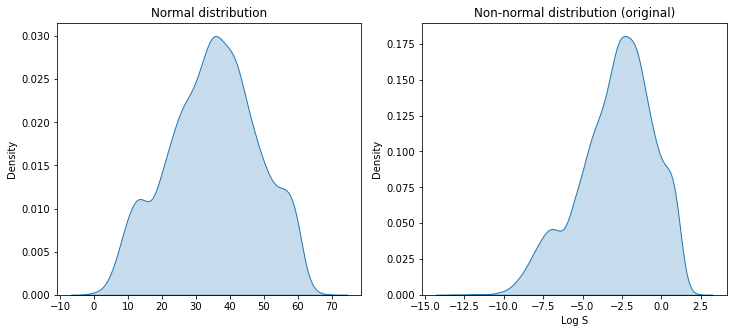

In [10]:
fig, ax = plt.subplots(1, 2)

sns.kdeplot(fitted_solubility, fill=True, label='Normal', ax=ax[0]).set(title='Normal distribution')


sns.kdeplot(data=df, x='Solubility', fill=True, label='Non-normal', ax=ax[1]).set(title='Non-normal distribution (original)', xlabel='Log S')

fig.set_figheight(5)
fig.set_figwidth(12)

plt.savefig('solubility_box_cox.jpg', bbox_inches='tight', dpi=300)

In [9]:
# creating X matrix using transformed descriptors
fitted_mw = pd.Series(fitted_mw)
fitted_mlogp = pd.Series(fitted_mlogp)
fitted_ap = pd.Series(fitted_ap)
fitted_rb = pd.Series(fitted_rb)

X_transformed = pd.concat([fitted_mw, fitted_mlogp, fitted_ap, fitted_rb], axis=1)
X_transformed

,0,1,2,3
0,5.666389,45.226962,-1.810327,4.083814
1,4.903902,43.610659,-0.138027,-1.764802
2,4.734495,43.347336,-0.258154,0.096419
3,6.252677,49.558438,-0.242769,3.100372
4,5.732609,43.693822,-0.665729,3.423776
...,...,...,...,...
9977,5.309737,43.830801,-0.798731,2.724094
9978,5.778001,40.884672,-1.091505,0.812801
9979,4.795278,44.046291,-0.417556,0.096419
9980,5.798300,46.408887,-0.707701,3.570456


In [10]:
# split dataset in training and test values
x_trans_train, x_trans_test, y_trans_train, y_trans_test = train_test_split(X_transformed, fitted_solubility)

### Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
# build linear regresson model
regr = LinearRegression()

# fit model using training set
regr.fit(x_train, y_train)

LinearRegression()

In [13]:
# intercept value
regr.intercept_

-1.187846952450287

In [14]:
# gradient value
regr.coef_

array([-0.37906887, -0.00356994,  0.06596439, -0.84715959])

In [15]:
# predict solubility values using the test set
regr_y_predict = regr.predict(x_test)

In [16]:
regr.score(x_train, y_train)

0.4367604180005409

In [17]:
regr.score(x_test, y_test)

0.49435624184845883

In [18]:
mean_squared_error(y_test, regr_y_predict)

# shows there is a high measure of error

2.8279030454071075

In [19]:
r2_score(y_test, regr_y_predict)

# shows poor goodness of fit

0.49435624184845883

[Text(0.5, 1.0, 'Multiple linear regression for predicting solubility'),
 Text(0.5, 0, 'experimental solubility values'),
 Text(0, 0.5, 'predicted solubility values')]

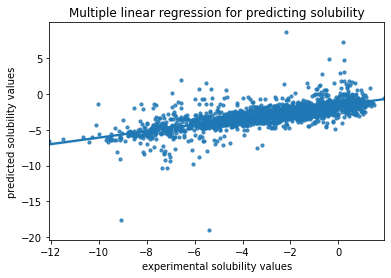

In [20]:
sns.regplot(x=y_test, y=regr_y_predict, scatter_kws={"s": 10}).set(title='Multiple linear regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')
# plt.savefig('mlr_delaney.jpg', bbox_inches='tight')

#### Using transformed data

In [21]:
regr2 = LinearRegression()
regr2.fit(x_trans_train, y_trans_train)

LinearRegression()

In [22]:
regr2.score(x_trans_train, y_trans_train)

0.5065133324084334

In [23]:
regr2.score(x_trans_test, y_trans_test)

0.5368805471694988

In [24]:
regr2_y_predict = regr2.predict(x_trans_test)

In [25]:
regr2_predict = inv_boxcox(regr2_y_predict, 1.7522356561991548) - 13.2
actual_y_trans_test = inv_boxcox(y_trans_test, 1.7522356561991548) - 13.2

[Text(0.5, 1.0, 'Multiple linear regression for predicting solubility'),
 Text(0.5, 0, 'experimental solubility values'),
 Text(0, 0.5, 'predicted solubility values')]

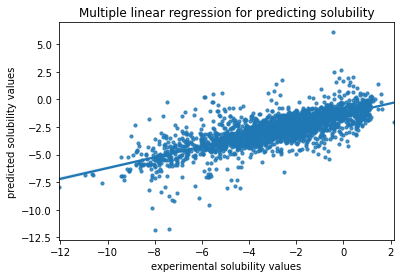

In [26]:
sns.regplot(x=actual_y_trans_test, y=regr2_predict, scatter_kws={"s": 10}).set(title='Multiple linear regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

### Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
# build random forest regresson model
rf = RandomForestRegressor()

# fit model using training set
rf.fit(x_train, y_train)

RandomForestRegressor()

In [29]:
# solubility values predicted using test labels
rf_y_predict = rf.predict(x_test)

In [30]:
rf.score(x_test, y_test)

0.7162784715945821

In [31]:
rf.score(x_train, y_train)

0.9534316592118277

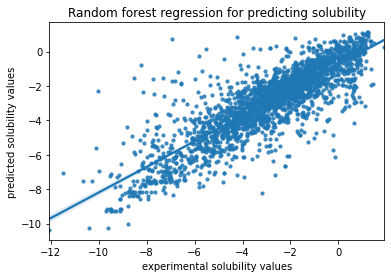

In [56]:
sns.regplot(x=y_test, y=rf_y_predict, scatter_kws={"s": 10}).set(title='Random forest regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')
plt.savefig('rfr_delaney.jpg', bbox_inches='tight', dpi=300)

#### Using transformed data

In [33]:
rf2 = RandomForestRegressor()
rf2.fit(x_trans_train, y_trans_train)

RandomForestRegressor()

In [34]:
rf2.score(x_trans_train, y_trans_train)

0.9537884523718791

In [35]:
rf2.score(x_trans_test, y_trans_test)

0.700812851677193

In [36]:
rf2_y_predict = rf2.predict(x_trans_test)

In [37]:
rf2_predict = inv_boxcox(rf2_y_predict, 1.7522356561991548) - 13.2
actual_y_trans_test = inv_boxcox(y_trans_test, 1.7522356561991548) - 13.2

[Text(0.5, 1.0, 'Random forest regression for predicting solubility'),
 Text(0.5, 0, 'experimental solubility values'),
 Text(0, 0.5, 'predicted solubility values')]

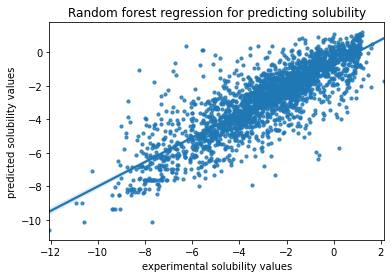

In [38]:
sns.regplot(x=actual_y_trans_test, y=rf2_predict, scatter_kws={"s": 10}).set(title='Random forest regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

### Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
# build gradient boosting regressor model
gb = GradientBoostingRegressor()

# fit model using training set
gb.fit(x_train, y_train)

GradientBoostingRegressor()

In [41]:
# solubility values predicted using test labels
gb_y_predict = gb.predict(x_test)

In [42]:
gb.score(x_test, y_test)

0.7066564635630794

In [43]:
gb.score(x_train, y_train)

0.7170774155766765

[Text(0.5, 1.0, 'Gradient boosting regression for predicting solubility'),
 Text(0.5, 0, 'experimental solubility values'),
 Text(0, 0.5, 'predicted solubility values')]

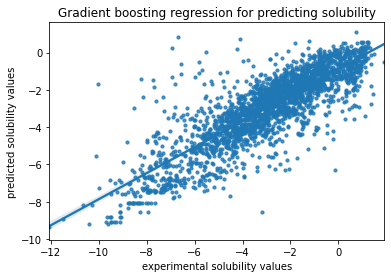

In [44]:
sns.regplot(x=y_test, y=gb_y_predict, scatter_kws={"s": 10}).set(title='Gradient boosting regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

#### Using transformed data

In [65]:
gb2 = GradientBoostingRegressor()
gb2.fit(x_trans_train, y_trans_train)

GradientBoostingRegressor()

In [66]:
gb2.score(x_trans_train, y_trans_train)

0.7111446399763942

In [67]:
gb2.score(x_trans_test, y_trans_test)

0.6961709577163289

In [68]:
gb2_y_predict = gb2.predict(x_trans_test)

In [69]:
gb2_predict = inv_boxcox(gb2_y_predict, 1.7522356561991548) - 13.2
actual_y_trans_test = inv_boxcox(y_trans_test, 1.7522356561991548) - 13.2

[Text(0.5, 1.0, 'Gradient boosting regression for predicting solubility'),
 Text(0.5, 0, 'experimental solubility values'),
 Text(0, 0.5, 'predicted solubility values')]

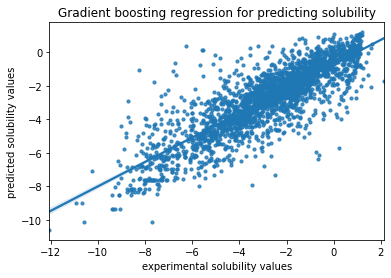

In [84]:
sns.regplot(x=actual_y_trans_test, y=rf2_predict, scatter_kws={"s": 10}).set(title='Gradient boosting regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

### Support Vector Machine

In [71]:
from sklearn.svm import SVR

In [72]:
# build svm regresson model
svm = SVR()

# fit model using training set
svm.fit(x_train, y_train)

SVR()

In [73]:
# solubility values predicted using test labels
svm_y_predict = svm.predict(x_test)

In [74]:
svm.score(x_test, y_test)

0.43099550543588605

In [75]:
svm.score(x_train, y_train)

0.42607486997335975

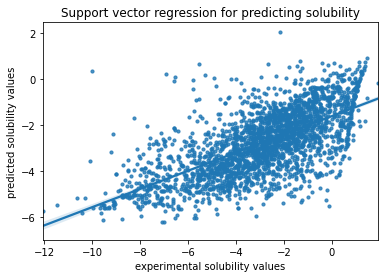

In [76]:
sns.regplot(x=y_test, y=svm_y_predict, scatter_kws={"s": 10}).set(title='Support vector regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')
plt.savefig('svr_delaney.jpg', bbox_inches='tight', dpi=300)

#### Using transformed data

In [85]:
svr2 = SVR()
svr2.fit(x_trans_train, y_trans_train)

SVR()

In [86]:
svr2.score(x_trans_train, y_trans_train)

0.49528546065400014

In [87]:
svr2.score(x_trans_test, y_trans_test)

0.5119117068106169

In [88]:
svr2_y_predict = svr2.predict(x_trans_test)

In [89]:
svr2_predict = inv_boxcox(svr2_y_predict, 1.7522356561991548) - 13.2
actual_y_trans_test = inv_boxcox(y_trans_test, 1.7522356561991548) - 13.2

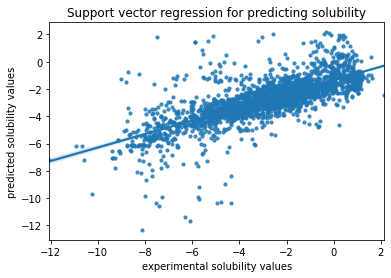

In [90]:
sns.regplot(x=actual_y_trans_test, y=svr2_predict, scatter_kws={"s": 10}).set(title='Support vector regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')
plt.savefig('svr_delaney_boxcox.jpg', bbox_inches='tight', dpi=300)